In [1]:
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
%matplotlib inline
import seaborn as sns
from math import exp

# 왼쪽으로 치우친 값(scale-free)을 로그변환하여 정규분포에 근사하게 변환
from scipy.stats import norm

pd.set_option('max_columns', 15, 'max_rows', 20)

# 한글 폰트 설정
import platform
your_os = platform.system()
if your_os == 'Linux':
    rc('font', family='NanumGothic')
elif your_os == 'Windows':
    ttf = "c:/Windows/Fonts/malgun.ttf" #맑은고딕
    font_name = font_manager.FontProperties(fname=ttf).get_name()
    rc('font', family=font_name)
elif your_os == 'Darwin': #이게 맥OS임
    rc('font', family='AppleGothic')
    
rc('axes', unicode_minus=False)

import warnings
warnings.filterwarnings("ignore")

## 요구사항

- 구매행태 데이터 기반으로 실버세대의 라이프스타일을 이해할 수 있는 특징을 분석 및 추정하고 이와 관련된 마케팅 전략을 제시
  (예시) 실버세대 고객 세분화, 여가 소비 분석을 통한 구매 활성화 방안 등

데이터 
-    기간 : 2014년 1월 1일 ~ 12월 31일 (1년) 
-    범위 : 55세~84세 고객의 상품군별 구매 내역 (서울·경기·부산 3개 지역에 위치한 일부 점포에 한함) 
-    데이터 목록


<font color='navy'><p>

- 데이터를 뽑는 기준 어떤 방향으로 데이터를 뽑아서 결과를 낼것인지 정하기
- 시각화 적절하게 하기
- 그 결과로 어떻게 활용할것인지
- 6/21에 발표 10분
- 분석보고서 / 코드 , 데이터
- 외부데이터를 썼을경우 그 데이터도 같이 제출
- 그룹바이를 하나씩해서 시각화하는건 점수 잘 못받음

In [2]:
shopper = pd.read_csv('Demo.csv', encoding = 'cp949')
purchase = pd.read_csv('구매내역정보.csv', encoding = 'cp949')
df1 = pd.merge(shopper, purchase, on='ID')

# 각 열별로 타입
df1.dtypes

# 결측값있나 확인 -> 결측값 없음
df1.info()

# 구매일자 시간으로
df1['구매일자'] = df1['구매일자'].astype(str).astype('datetime64')
# 년,월,일,요일 열 만들기
df1['년도'] = df1['구매일자'].dt.year
df1['월'] = df1['구매일자'].dt.month
df1['일'] = df1['구매일자'].dt.day
df1['요일'] = df1['구매일자'].dt.weekday#day_name()

# df1 csv파일 내보내서 저장하기
df1.to_csv('df1.csv',index=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101692 entries, 0 to 101691
Data columns (total 12 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   ID      101692 non-null  int64 
 1   성별      101692 non-null  int64 
 2   연령      101692 non-null  int64 
 3   거주지역    101692 non-null  object
 4   상품대분류명  101692 non-null  object
 5   상품중분류명  101692 non-null  object
 6   구매지역    101692 non-null  object
 7   구매일자    101692 non-null  int64 
 8   구매시간    101692 non-null  int64 
 9   구매수량    101692 non-null  int64 
 10  구매금액    101692 non-null  int64 
 11  취소여부    101692 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 10.1+ MB


# 구해볼 것

#### 1. 성별로 구분 -> 어느 성별이 더 많이 구매하는지
#### 2. 거주지역 -> 어디 사는 사람이 더 많이 구매하는지
#### 3. 시간 -> 무슨 달에 더 구매하는지/ 무슨 요일에 더 구매하는지 => 시간에 따라서 어떤 물건을 구매하는지
#### 4. 연령대 -> 어느 연령대의 구매가 더 많은지 => 연령대에 따라 무슨 제품을 더 구매하는지
#### 5. 구매취소는 어느 지역, 어느 물건이 많은지 => (구매수량-구매취소)구해서 진짜로 최종 구매한 개수 구하기
#### 6. 가격 분위수 만들어서 각 분위수별로 어떤 사람이 많은지
#### 7. 거주지역이랑 구매지역


In [3]:
df = pd.read_csv('df1.csv')

# 구매일자 시간으로 바꾸기
df['구매일자'] = df['구매일자'].astype(str).astype('datetime64')
df.head()

,ID,성별,연령,거주지역,상품대분류명,상품중분류명,구매지역,...,구매수량,구매금액,취소여부,년도,월,일,요일
0,478207946,1,84,서울 성동구,가전제품,컴퓨터주변기기,서울 동대문구,...,1,59000,0,2014,12,19,4
1,478207946,1,84,서울 성동구,가전제품,TV/AV,서울 동대문구,...,1,106000,0,2014,10,31,4
2,478207946,1,84,서울 성동구,가전제품,주방가전,서울 중구,...,1,37000,0,2014,8,15,4
3,478207946,1,84,서울 성동구,의류잡화,여성용의류-이너웨어,서울 동대문구,...,1,118000,0,2014,3,22,5
4,479806984,1,84,서울 서초구,생활잡화,화장품,서울 중구,...,1,22000,0,2014,7,4,4


### 월별/요일별/시간대별 구매량 -> 구매 많은 월,요일,시간 찾기
#### +고가제품은 언제 구매를 가장 많이하는지
#### +저가제품은 언제 구매가 가장 많은지
#### 고가제품에 들어가는 품목 / 저가제품에 들어가는 품목

In [4]:
# 요일 함수
def day(x):
    if x == 0 :
        return '월요일'
    elif x == 1 :
        return '화요일'
    elif x == 2 :
        return '수요일'
    elif x == 3 :
        return '목요일'
    elif x == 4 :
        return '금요일'
    elif x == 5 :
        return '토요일'
    else :
        return '일요일'
    
# 시간대 함수
def time(x):
    if 23<= x or x<3 :
        return '23~02'
    elif x<7 :
        return '03~06'
    elif x<11 :
        return '07~10'
    elif x<15 :
        return '11~14'
    elif x<19 :
        return '15~18'
    else :
        return '19~22'
    
# 시간대 함수2
def time2(x):
    if x == '23~02' or x=='03~06' :
        return '23~06'
    else :
        return x
    
# 월 분기 함수
def month(x):
    if x<4 :
        return '1분기'
    elif x<7 :
        return '2분기'
    elif x<10 :
        return '3분기'
    else :
        return '4분기'

In [5]:
df = pd.read_csv('df1.csv')
df1 = df.drop(['거주지역','구매지역','구매일자'],axis=1)
del(df)

### 시간대별 구매량
##### 시간대 나누기

In [6]:
df1['시간대'] = df1['구매시간'].apply(time)
df1.시간대.value_counts()

# 3 ~ 6과 23 ~ 02는 구매 수가 너무 작아서 23 ~ 6으로 합치기
df1['시간대'] = df1['시간대'].apply(time2)

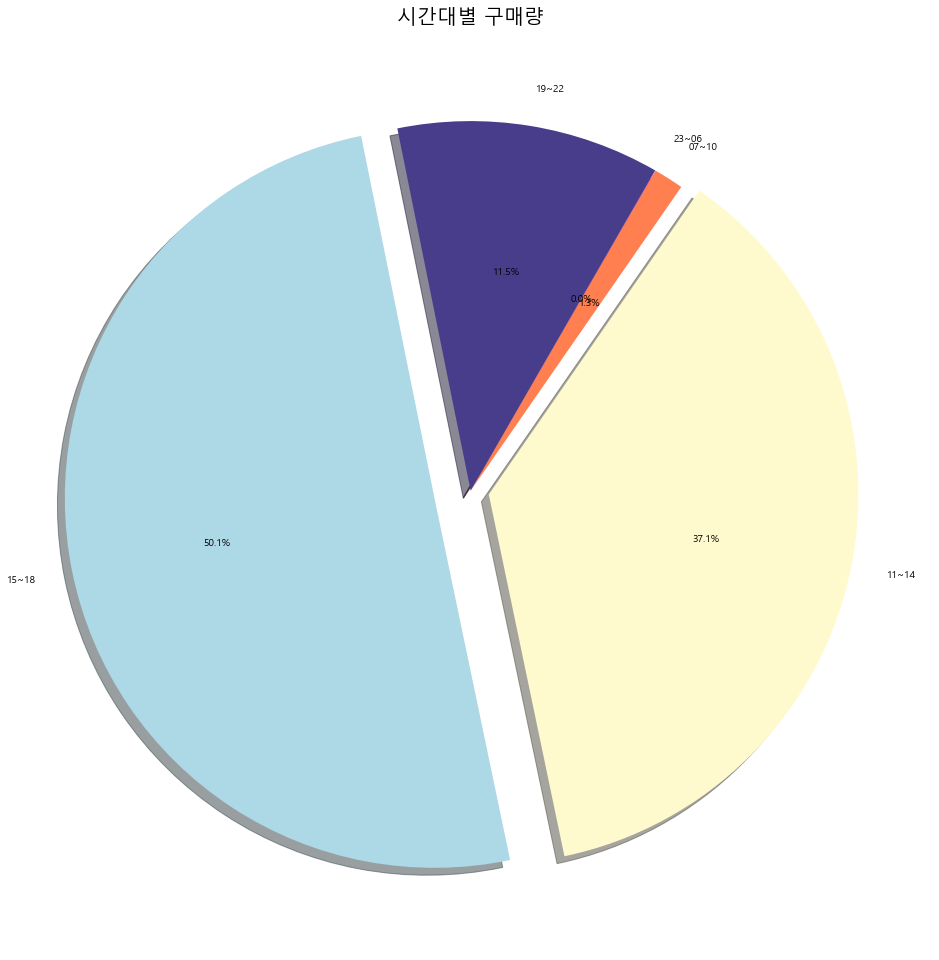

In [7]:
a=df1.groupby(['시간대'])['ID'].agg([('구매횟수','count')]).reset_index()


colors = ['coral','lemonchiffon','lightblue','darkslateblue','mediumorchid']

plt.figure(figsize=(17,17)) 

explode1 = [0,0.05,0.1,0,0]

plt.pie(x=a.구매횟수 ,labels = a.시간대, explode = explode1, 
        autopct='%.1f%%', startangle=60, counterclock = False, shadow=True, colors=colors )
plt.title('시간대별 구매량', size=20)

plt.show()

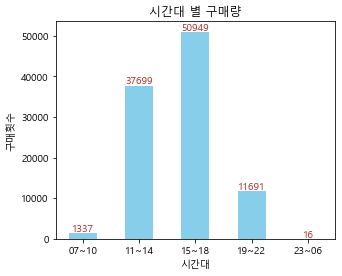

In [8]:
a=df1.groupby(['시간대'])['ID'].agg([('구매횟수','count')]).reset_index()

x = a.시간대
y = a.구매횟수


plt.figure(figsize=(5,4)) 
plt.bar(x,y, color = 'skyblue', width = 0.5)
plt.xticks(rotation=0)
plt.xlabel("시간대")
plt.ylabel("구매횟수")
plt.title("시간대 별 구매량")

for i,v in enumerate(x):
    plt.text(v, y[i], y[i],fontsize=10, color='firebrick',
               horizontalalignment='center', verticalalignment='bottom')

plt.show()

대부분 15시~ 18시 사이에 많이 구매 (절반정도) 그 다음으로는 11시~ 14시 => 많이 움직이는 시간대에 구매율이 많음

### 월 별 구매량
##### 월을 1,2,3,4분기로 나누기

In [9]:
df1['분기'] = df1['월'].apply(month)
df1.분기.value_counts()

4분기    29245
2분기    25934
3분기    25382
1분기    21131
Name: 분기, dtype: int64

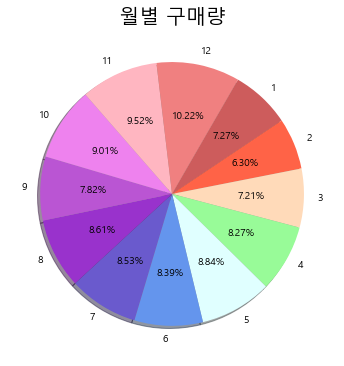

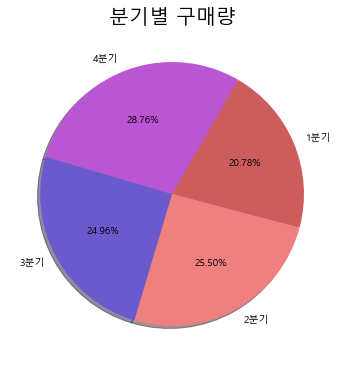

In [10]:
colors = ['indianred','tomato','peachpuff','palegreen','lightcyan','cornflowerblue',
          'slateblue','darkorchid','mediumorchid','violet','lightpink','lightcoral']
colors2 = ['indianred','lightcoral','slateblue','mediumorchid']

#월별
a=df1.groupby(['월'])['ID'].agg([('구매횟수','count')]).reset_index()
plt.figure(figsize=(13,13)) 
plt.subplot(1,2,1)
plt.pie(x=a.구매횟수 ,labels = a.월, 
        autopct='%.2f%%', startangle=60, counterclock = False, shadow=True, colors=colors )
plt.title('월별 구매량', size=20)

#분기별
b=df1.groupby(['분기'])['ID'].agg([('구매횟수','count')]).reset_index()
plt.figure(figsize=(13,13)) 
plt.subplot(1,2,2)
plt.pie(x=b.구매횟수 ,labels = b.분기, 
        autopct='%.2f%%', startangle=60, counterclock = False, shadow=True, colors=colors2 )
plt.title('분기별 구매량', size=20)


plt.show()

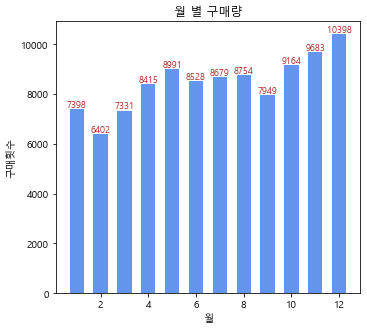

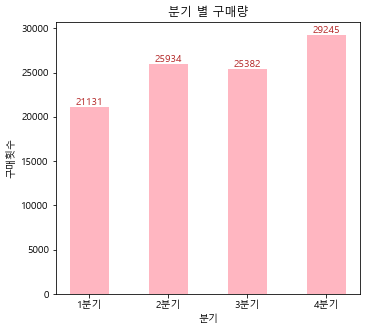

In [11]:
#월별
a=df1.groupby(['월'])['ID'].agg([('구매횟수','count')]).reset_index()
x = a.월
y = a.구매횟수

plt.figure(figsize=(12,5)) 
plt.subplot(1,2,1)
plt.bar(x,y, color = 'cornflowerblue', width = 0.6)
plt.xticks(rotation=0)
plt.xlabel("월")
plt.ylabel("구매횟수")
plt.title("월 별 구매량")

for i,v in enumerate(x):
    plt.text(v, y[i], y[i],fontsize=9, color='firebrick',
               horizontalalignment='center', verticalalignment='bottom')


#분기별
b=df1.groupby(['분기'])['ID'].agg([('구매횟수','count')]).reset_index()
x = b.분기
y = b.구매횟수

plt.figure(figsize=(12,5)) 
plt.subplot(1,2,2)
plt.bar(x,y, color = 'lightpink', width = 0.5)
plt.xticks(rotation=0)
plt.xlabel("분기")
plt.ylabel("구매횟수")
plt.title("분기 별 구매량")

for i,v in enumerate(x):
    plt.text(v, y[i], y[i],fontsize=10, color='firebrick',
               horizontalalignment='center', verticalalignment='bottom')

plt.show()

월별,분기별 구매 횟수는 비슷 -> 월별,분기별 구매 금액 비교해보기

### 요일 별 구매량

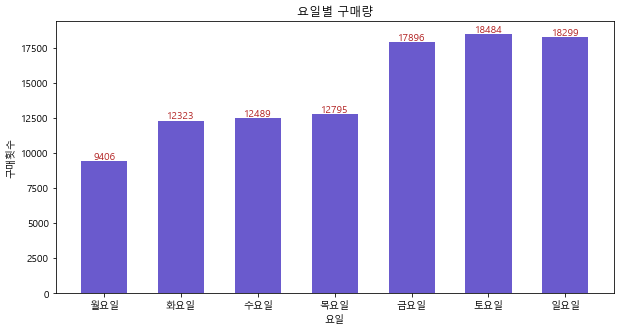

In [12]:
x = df1.groupby(['요일'])['ID'].agg([('구매횟수','count')]).reset_index().요일.apply(day)
y = df1.groupby(['요일'])['ID'].agg([('구매횟수','count')]).reset_index().구매횟수


plt.figure(figsize=(10,5)) 
plt.bar(x,y, color = 'slateblue', width = 0.6)
plt.xticks(rotation=0)
plt.xlabel("요일")
plt.ylabel("구매횟수")
plt.title("요일별 구매량")

for i,v in enumerate(x):
    plt.text(v, y[i], y[i],fontsize=10, color='firebrick',
               horizontalalignment='center', verticalalignment='bottom')

plt.show()

금,토,일의 구매횟수가 많고 화,수,목 이 그 다음으로 비슷 월요일이 가장 적은 구매횟수

### 월, 요일, 시간 구매횟수 관계

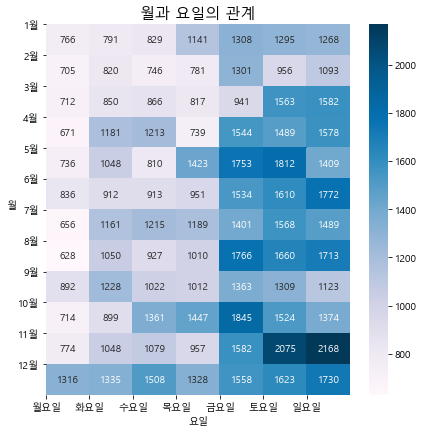

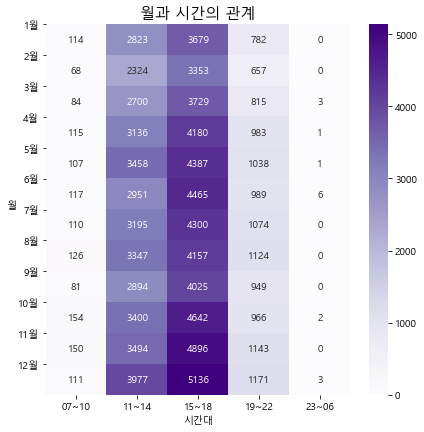

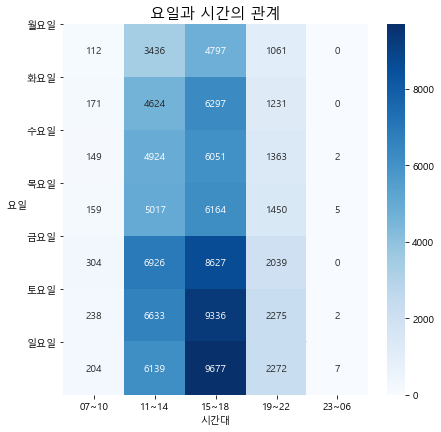

In [13]:
pt_df = pd.pivot_table(df1, index='월', columns='요일',
                  values='ID', aggfunc='count', fill_value=0)

pt_df1 = pd.pivot_table(df1, index='월', columns='시간대',
                  values='ID', aggfunc='count', fill_value=0)

pt_df2 = pd.pivot_table(df1, index='요일', columns='시간대',
                  values='ID', aggfunc='count', fill_value=0)


m=[str(i+1) + '월' for i in range(12) ]
d = ['월요일','화요일','수요일','목요일','금요일','토요일','일요일']

# 월, 요일
plt.figure(figsize=(15,15))
plt.subplot(2,2,1)
sns.heatmap(pt_df, cmap='PuBu', annot=True, fmt=".0f")

plt.title('월과 요일의 관계', size=15)
plt.xlabel('요일', size=10)
plt.ylabel('월 ', rotation=0, size=10)
plt.xticks(range(len(pt_df.columns)),d)
plt.yticks(range(len(pt_df.index)), m, rotation=0)

# 월, 시간
plt.figure(figsize=(15,15))
plt.subplot(2,2,2)
sns.heatmap(pt_df1, cmap='Purples', annot=True, fmt=".0f")

plt.title('월과 시간의 관계', size=15)
plt.xlabel('시간대', size=10)
plt.ylabel('월 ', rotation=0, size=10)
plt.yticks(range(len(pt_df.index)), m, rotation=0)

# 요일, 시간
plt.figure(figsize=(15,15))
plt.subplot(2,2,3)
sns.heatmap(pt_df2, cmap='Blues', annot=True, fmt=".0f")

plt.title('요일과 시간의 관계', size=15)
plt.xlabel('시간대', size=10)
plt.ylabel('요일   ', rotation=0, size=10)
plt.yticks(range(len(pt_df.columns)),d, rotation=0)

plt.show()

##### 월, 요일
아무래도 금토일의 구매율이 높고
12월은 모든 요일의 구매율이 높은 편이다.
토요일, 일요일 모두 11월에 구매율이 가장높다.
토요일, 일요일 모두 2월에 구매율이 낮다.

##### 월, 시간
11~ 14와 15~ 18의 구매가 아무래도 많다보니 두 시간대에서의 구매율이 높다.
각 시간대 별로 비슷하지만
11~ 14에는 5,8,10,11,12월 / 15~ 18에는 6,10,11,12월이 높은 편에 속한다.

##### 요일, 시간
11~ 14와 15~ 18의 구매가 아무래도 많다보니 두 시간대에서의 구매율이 높다.
11~ 14에는 금,토,일 / 15~ 18에도 금,토,일에 구매가 높은데
그중 15~ 18에서 일요일이 가장 높고, 토요일이 그 다음이다.

#### 구매 금액 비교해보기

In [14]:
# 구매금액이 0이하인 행들 제거
df2 = df1[df1.구매금액 > 0]
df2.describe().astype(int)

,ID,성별,연령,구매시간,구매수량,구매금액,취소여부,년도,월,일,요일
count,93139,93139,93139,93139,93139,93139,93139,93139,93139,93139,93139
mean,502661756,1,60,15,1,100950,0,2014,6,15,3
std,292608831,0,5,2,8,319698,0,0,3,8,1
min,741463,1,55,1,1,1000,0,2014,1,1,0
25%,250756143,2,56,13,1,9000,0,2014,4,8,2
50%,503932225,2,59,15,1,25000,0,2014,7,15,4
75%,761620039,2,63,17,1,78000,0,2014,10,23,5
max,999494396,2,84,22,837,23901000,0,2014,12,31,6


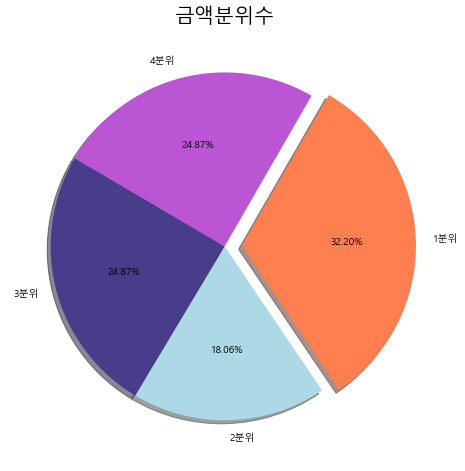

In [15]:
Q1 = df2.구매금액.quantile(.25)
Q2 = df2.구매금액.quantile(.5)
Q3 = df2.구매금액.quantile(.75)
Q4 = df2.구매금액.quantile(.1)

def quan(x):
    if x<= Q1:
        return '1분위'
    elif x<= Q2:
        return '2분위'
    elif x<= Q3:
        return '3분위'
    else :
        return '4분위'

df2['금액분위수'] = df2.구매금액.apply(quan)



a=df2.groupby(['금액분위수'])['ID'].agg([('구매횟수','count')]).reset_index()

colors = ['coral','lightblue','darkslateblue','mediumorchid']
plt.figure(figsize=(10,8)) 
explode1 = [0.1,0,0,0]

plt.pie(x=a.구매횟수 ,labels = a.금액분위수, explode = explode1, 
        autopct='%.2f%%', startangle=60, counterclock = False, shadow=True, colors=colors )
plt.title('금액분위수', size=20)

plt.show()

금액 1분위수 구매수가 가장 높고, 3분위 4분위 구매율은 비슷
1분위수는 구매금액이 9000원이하
2분위수는 25000원이하
3분위수는 78000원이하
최고 금액은 23901000원

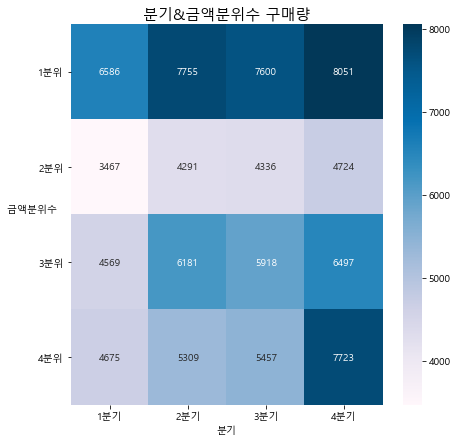

In [16]:
# 분기&금액분위수 구매수 관계

pt_df1 = pd.pivot_table(df2, index='금액분위수', columns='분기', values='ID', aggfunc='count', fill_value=0)

plt.figure(figsize=(7,7))
sns.heatmap(pt_df1, cmap='PuBu', annot=True, fmt=".0f")

plt.title('분기&금액분위수 구매량', size=15)
plt.xlabel('분기', size=10)
plt.ylabel('금액분위수 ', rotation=0, size=10)
plt.yticks(rotation=0)
plt.show()

### 월별,분기별 구매 금액 관련

In [17]:
df2.groupby(['분기','금액분위수'])['구매금액'].agg([('구매합','sum')])#.reset_index()

#df2.groupby(['금액분위수','분기'])['구매금액'].agg([('구매합','sum')])#.reset_index()

구매합
분기  금액분위수            
1분기 1분위      36253000
    2분위      56424000
    3분위     205017000
    4분위    1443329000
2분기 1분위      43121000
    2분위      69282000
    3분위     278637000
    4분위    1474223000
3분기 1분위      41631000
    2분위      69554000
    3분위     270222000
    4분위    1907036000
4분기 1분위      44613000
    2분위      77028000
    3분위     294070000
    4분위    3091949000

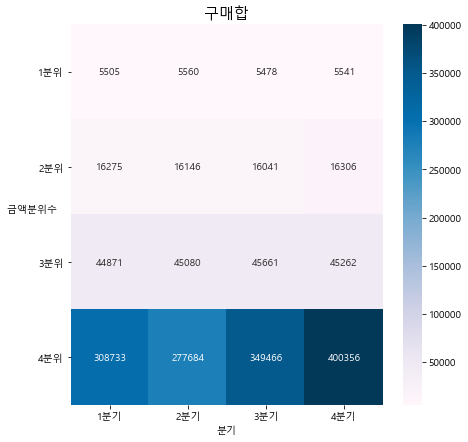

In [18]:
pt_df2 = pd.pivot_table(df2, index='금액분위수', columns='분기',
                  values='구매금액', aggfunc='mean', fill_value=0)

plt.figure(figsize=(7,7))
sns.heatmap(pt_df2, cmap='PuBu', annot=True, fmt=".0f")

plt.title('구매합', size=15)
plt.xlabel('분기', size=10)
plt.ylabel('금액분위수 ', rotation=0, size=10)
plt.yticks(rotation=0)
plt.show()

4분위수 제품의 가격이 높아서 색이 진함

## 성별 별 구매 높은 연령대
## 성별별,연령대별 어느 제품을 많이 구매하는지

In [19]:
df = pd.read_csv('df1.csv')

# 나이 최소, 최대 알아보기
df.연령.describe()

count    101692.000000
mean         60.732634
std           5.808983
min          55.000000
25%          56.000000
50%          59.000000
75%          63.000000
max          84.000000
Name: 연령, dtype: float64

In [20]:
# 나이대 구분 함수
def age_fun(x):
    if x < 50:
        return '50세미만'
    elif x<60:
        return '50대'
    elif x<70:
        return '60대'
    elif x<80:
        return '70대'
    elif x<90:
        return '80대'
    else:
        return '90세이상'
# 연령대 열추가
df['연령대'] = df.연령.apply(age_fun)

#### 성별 별 구매가 높은 연령대

In [21]:
df.groupby(['성별','연령대'])[['연령대']].agg([('구매횟수','count')])#.reset_index()

연령대
         구매횟수
성별 연령대       
1  50대   9065
   60대   6572
   70대   2499
   80대    406
2  50대  46764
   60대  30088
   70대   5579
   80대    719

In [22]:
a=df.groupby('성별')['ID'].agg([('구매횟수','count')]).reset_index()

a1=df.query('성별==1').groupby('연령대')['ID'].agg([('구매횟수','count')]).reset_index()
a2=df.query('성별==2').groupby('연령대')['ID'].agg([('구매횟수','count')]).reset_index()

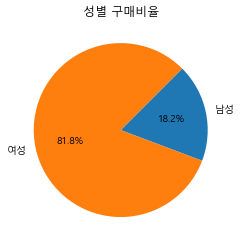

In [23]:
label1=['남성','여성']

plt.pie(x=a.구매횟수 ,labels = label1, autopct='%.1f%%', startangle=45, counterclock = False )
plt.title('성별 구매비율')

plt.show()

여성의 구매횟수가 남성에 비해 4배 이상 많다.

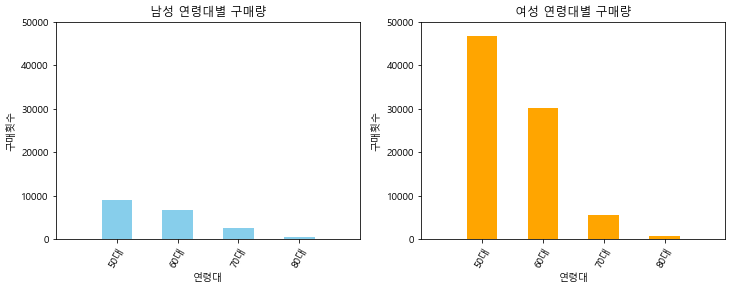

In [24]:
# 1
x1 = a1.연령대
y1 = a1.구매횟수

plt.figure(figsize=(12,4)) 
plt.subplot(1,2,1)
plt.bar(x1,y1, color = 'skyblue', width = 0.5)
plt.xticks(rotation=60)
plt.xlabel("연령대")
plt.ylabel("구매횟수")
plt.xlim(-1, 4)
plt.ylim(0, 50000)
plt.title("남성 연령대별 구매량")

#2
x2 = a2.연령대
y2 = a2.구매횟수

plt.subplot(1,2,2)
plt.bar(x2,y2, color = 'orange',width = 0.5)
plt.xticks(rotation=60)
plt.xlabel("연령대")
plt.ylabel("구매횟수")
plt.xlim(-1, 4)
plt.ylim(0, 50000)
plt.title("여성 연령대별 구매량")

plt.show()

아무래도 연령대 구매횟수는 남성, 여성 모두 50대의 구매가 가장 많다.

### 성별 별 어느 제품을 많이 구매하는지

In [25]:
df.groupby(['성별','상품대분류명','상품중분류명'])['ID'].agg([('구매횟수','count')])#.reset_index()

구매횟수
성별 상품대분류명 상품중분류명              
1  가구     가구               110
   가전제품   PC/노트북/프린터/카메라   115
          TV/AV            260
          생활가전             726
          주방가전             823
...                        ...
2  의류잡화   여성용의류-이너웨어      1201
          여성용의류-정장류       3683
          여성용의류-캐주얼        105
          주얼리              101
          패션잡화            1820

[62 rows x 1 columns]

#### 성별별 상품대분류 구매 순위

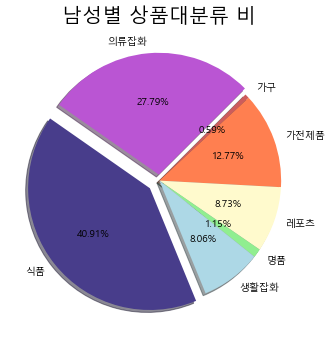

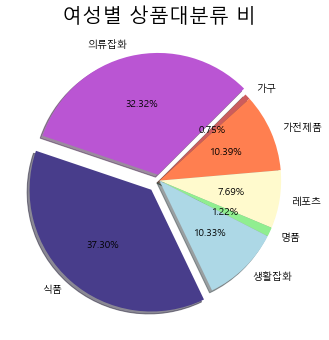

In [26]:
b=df.groupby(['성별','상품대분류명'])['ID'].agg([('구매횟수','count')]).reset_index()

b1=df.query('성별==1').groupby(['성별','상품대분류명'])['ID'].agg([('구매횟수','count')]).reset_index()
b2=df.query('성별==2').groupby(['성별','상품대분류명'])['ID'].agg([('구매횟수','count')]).reset_index()

colors = ['indianred','coral','lemonchiffon','lightgreen','lightblue','darkslateblue','mediumorchid']

# 1
plt.figure(figsize=(12,10)) 
plt.subplot(1,2,1)
explode1 = [0,0,0,0,0,0.1,0.05]

plt.pie(x=b1.구매횟수 ,labels = b1.상품대분류명, explode = explode1, 
        autopct='%.2f%%', startangle=45, counterclock = False, shadow=True, colors=colors )
plt.title('남성별 상품대분류 비', size=20)


# 2
plt.figure(figsize=(12,10)) 
plt.subplot(1,2,2)
explode2 = [0,0,0,0,0,0.1,0.05]

plt.pie(x=b2.구매횟수 ,labels = b2.상품대분류명, explode = explode2, 
        autopct='%.2f%%', startangle=45, counterclock = False, shadow=True, colors=colors )
plt.title('여성별 상품대분류 비', size=20)


plt.show()

남성 상품대분류 Top1. 식품 Top2. 의류잡화 Top3. 가전제품

여성 상품대분류 Top1. 식품 Top2. 의류잡화 Top3. 가전제품

남성 여성 모두 상품대분류 상위 3개 순위는 같다. 그렇지만 여성의 경우 가전제품과 생활잡화의 비율이 거의 동일하다.

#### 성별별 상품대분류 1,2,3위 중 상품중분류 순위

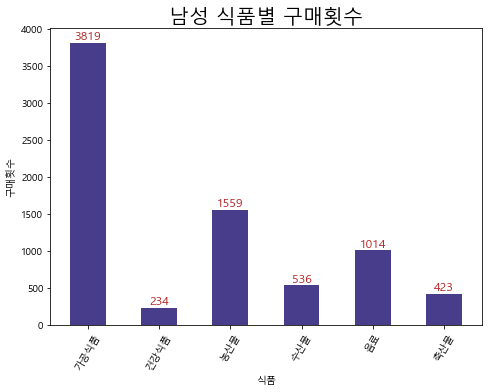

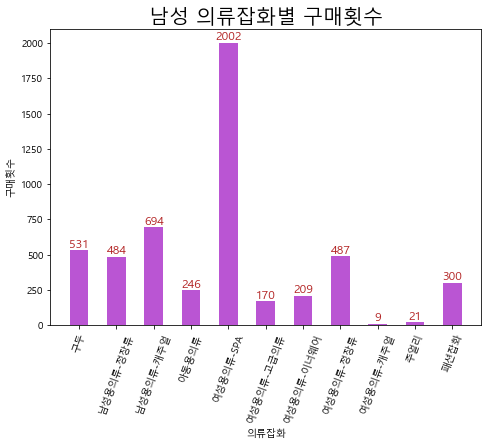

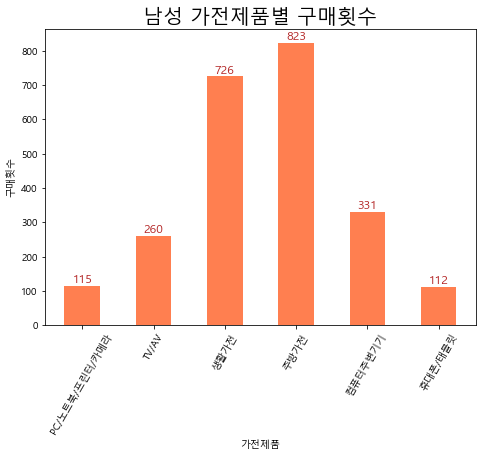

In [27]:
b_2 = df.groupby(['성별','상품대분류명','상품중분류명'])['ID'].agg([('구매횟수','count')]).reset_index()

b1_2 = b_2.query('성별==1 ')

b1_food = b1_2.query('상품대분류명=="식품"')
b1_clothes = b1_2.query('상품대분류명=="의류잡화"')
b1_elect = b1_2.query('상품대분류명=="가전제품"')

# 남성
# Top1 식품
x1 = b1_food.상품중분류명
y1 = b1_food.구매횟수

plt.figure(figsize=(17,12)) 
plt.subplot(2,2,1)
plt.bar(x1,y1, color = 'darkslateblue', width = 0.5)
plt.xticks(rotation=60)
plt.xlabel("식품")
plt.ylabel("구매횟수")

plt.title("남성 식품별 구매횟수", size=20)

for i,v in enumerate(x1):
    plt.text(v, y1.iloc[i], y1.iloc[i],fontsize=12, color='firebrick',
               horizontalalignment='center', verticalalignment='bottom')

# Top2 의류잡화
x2 = b1_clothes.상품중분류명
y2 = b1_clothes.구매횟수

plt.figure(figsize=(17,12)) 
plt.subplot(2,2,2)
plt.bar(x2,y2, color = 'mediumorchid', width = 0.5)
plt.xticks(rotation=70)
plt.xlabel("의류잡화")
plt.ylabel("구매횟수")

plt.title("남성 의류잡화별 구매횟수", size=20)

for i,v in enumerate(x2):
    plt.text(v, y2.iloc[i], y2.iloc[i],fontsize=12, color='firebrick',
               horizontalalignment='center', verticalalignment='bottom')


# Top3 가전제품
x3 = b1_elect.상품중분류명
y3 = b1_elect.구매횟수

plt.figure(figsize=(17,12)) 
plt.subplot(2,2,3)
plt.bar(x3,y3, color = 'coral', width = 0.5)
plt.xticks(rotation=60)
plt.xlabel("가전제품")
plt.ylabel("구매횟수")

plt.title("남성 가전제품별 구매횟수", size=20)

for i,v in enumerate(x3):
    plt.text(v, y3.iloc[i], y3.iloc[i],fontsize=12, color='firebrick',
               horizontalalignment='center', verticalalignment='bottom')


plt.show()


식품 중 중분류 상품 Top1. 가공식품 Top2. 농산물 Top3. 음료

의류잡화 중 중분류 상품 Top1. 여성용의류_SPA Top2. 남성용의류_캐주얼 Top3. 구두

가전제품 중 중분류 상품 Top1. 주방가전 Top2. 생활가전 Top3. 컴퓨터주변기기

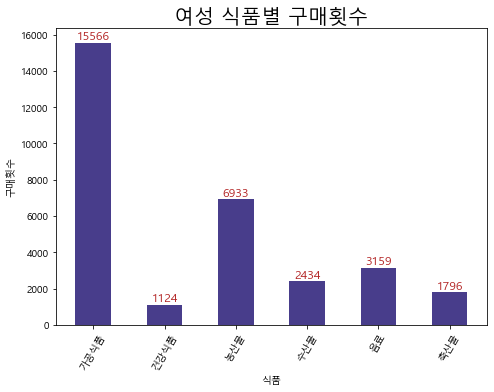

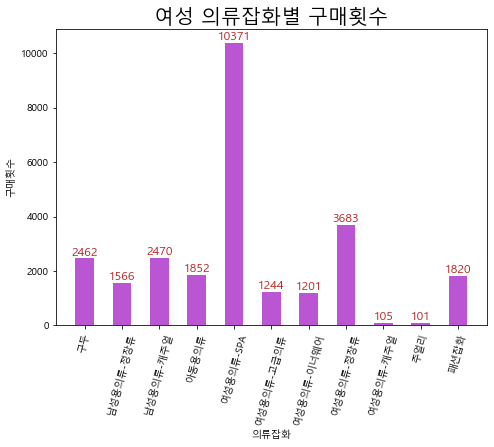

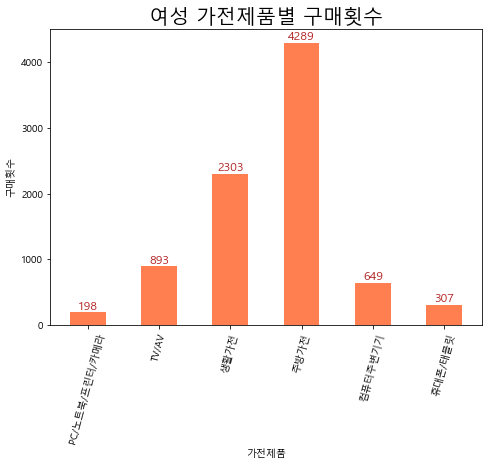

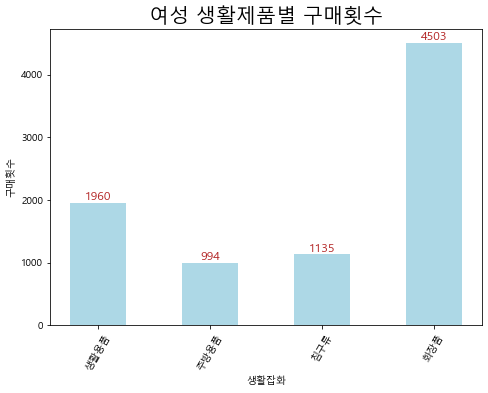

In [28]:
b2_2 = b_2.query('성별==2')

b2_food = b2_2.query('상품대분류명=="식품"')
b2_clothes = b2_2.query('상품대분류명=="의류잡화"')
b2_elect = b2_2.query('상품대분류명=="가전제품"')
b2_life = b2_2.query('상품대분류명=="생활잡화"')

# 여성

# Top1 식품
x1 = b2_food.상품중분류명
y1 = b2_food.구매횟수

plt.figure(figsize=(17,12)) 
plt.subplot(2,2,1)
plt.bar(x1,y1, color = 'darkslateblue', width = 0.5)
plt.xticks(rotation=60)
plt.xlabel("식품")
plt.ylabel("구매횟수")

plt.title("여성 식품별 구매횟수", size=20)

for i,v in enumerate(x1):
    plt.text(v, y1.iloc[i], y1.iloc[i],fontsize=12, color='firebrick',
               horizontalalignment='center', verticalalignment='bottom')


# Top2 의류잡화
x2 = b2_clothes.상품중분류명
y2 = b2_clothes.구매횟수

plt.figure(figsize=(17,12)) 
plt.subplot(2,2,2)
plt.bar(x2,y2, color = 'mediumorchid', width = 0.5)
plt.xticks(rotation=75)
plt.xlabel("의류잡화")
plt.ylabel("구매횟수")

plt.title("여성 의류잡화별 구매횟수", size=20)

for i,v in enumerate(x2):
    plt.text(v, y2.iloc[i], y2.iloc[i],fontsize=12, color='firebrick',
               horizontalalignment='center', verticalalignment='bottom')


# Top3 가전제품
x3 = b2_elect.상품중분류명
y3 = b2_elect.구매횟수

plt.figure(figsize=(17,12)) 
plt.subplot(2,2,3)
plt.bar(x3,y3, color = 'coral', width = 0.5)
plt.xticks(rotation=75)
plt.xlabel("가전제품")
plt.ylabel("구매횟수")

plt.title("여성 가전제품별 구매횟수", size=20)

for i,v in enumerate(x3):
    plt.text(v, y3.iloc[i], y3.iloc[i],fontsize=12, color='firebrick',
               horizontalalignment='center', verticalalignment='bottom')


# Top4 생활잡화
x4 = b2_life.상품중분류명
y4 = b2_life.구매횟수

plt.figure(figsize=(17,12)) 
plt.subplot(2,2,4)
plt.bar(x4,y4, color = 'lightblue', width = 0.5)
plt.xticks(rotation=60)
plt.xlabel("생활잡화")
plt.ylabel("구매횟수")

plt.title("여성 생활제품별 구매횟수", size=20)

for i,v in enumerate(x4):
    plt.text(v, y4.iloc[i], y4.iloc[i],fontsize=12, color='firebrick',
               horizontalalignment='center', verticalalignment='bottom')


plt.show()

식품 중 중분류 상품 Top1. 가공식품 Top2. 농산물 Top3. 음료

의류잡화 중 중분류 상품 Top1. 여성용의류_SPA Top2. 여성용의류_정장류 Top3. 남성용의류_캐주얼 Top4. 구두

가전제품 중 중분류 상품 Top1. 주방가전 Top2. 생활가전 Top3. TV/AV

생활잡화 중 중분류 상품 Top1. 화장품 Top2. 생활용품

### 연령대 별 어느 제품을 많이 구매하는지

##### 어느 연령대가 구매를 많이하는지

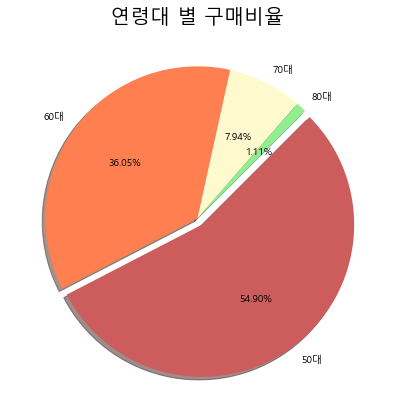

In [29]:
q=df.groupby('연령대')['ID'].agg([('구매횟수','count')]).reset_index()

plt.figure(figsize=(7,7)) 
explode1 = [0.05,0,0,0]

plt.pie(x=q.구매횟수 ,labels = q.연령대, explode = explode1, 
        autopct='%.2f%%', startangle=45, counterclock = False, shadow=True, colors=colors )
plt.title('연령대 별 구매비율', size=20)

plt.show()

50대가 절반 이상을 차지한다.

In [30]:
df.groupby(['연령대','상품대분류명','상품중분류명'])['ID'].agg([('구매횟수','count')])#.reset_index()

구매횟수
연령대 상품대분류명 상품중분류명              
50대 가구     가구               457
    가전제품   PC/노트북/프린터/카메라   208
           TV/AV            614
           생활가전            1711
           주방가전            2748
...                         ...
80대 의류잡화   여성용의류-SPA        148
           여성용의류-고급의류         5
           여성용의류-이너웨어         7
           여성용의류-정장류         47
           패션잡화              13

[121 rows x 1 columns]

#### 연령대별 상품대분류 구매 순위 TOP1,2

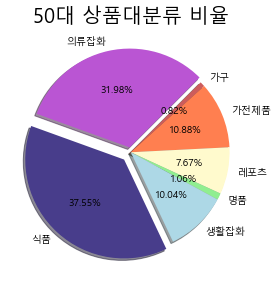

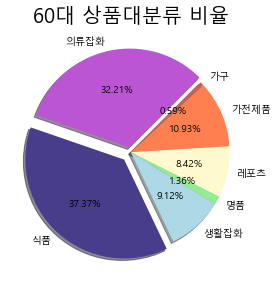

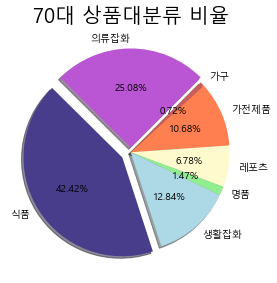

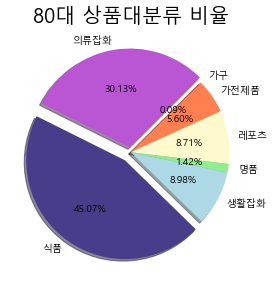

In [31]:
c=df.groupby(['연령대','상품대분류명'])['ID'].agg([('구매횟수','count')]).reset_index()

c50=df.query('연령대=="50대"').groupby(['연령대','상품대분류명'])['ID'].agg([('구매횟수','count')]).reset_index()
c60=df.query('연령대=="60대"').groupby(['연령대','상품대분류명'])['ID'].agg([('구매횟수','count')]).reset_index()
c70=df.query('연령대=="70대"').groupby(['연령대','상품대분류명'])['ID'].agg([('구매횟수','count')]).reset_index()
c80=df.query('연령대=="80대"').groupby(['연령대','상품대분류명'])['ID'].agg([('구매횟수','count')]).reset_index()


colors = ['indianred','coral','lemonchiffon','lightgreen','lightblue','darkslateblue','mediumorchid']

# 50대
plt.figure(figsize=(12,10)) 
plt.subplot(2,2,1)
explode1 = [0,0,0,0,0,0.1,0.05]

plt.pie(x=c50.구매횟수 ,labels = c50.상품대분류명, explode = explode1, 
        autopct='%.2f%%', startangle=45, counterclock = False, shadow=True, colors=colors )
plt.title('50대 상품대분류 비율', size=20)


# 60대
plt.figure(figsize=(12,10)) 
plt.subplot(2,2,2)
explode2 = [0,0,0,0,0,0.1,0.05]

plt.pie(x=c60.구매횟수 ,labels = c60.상품대분류명, explode = explode2, 
        autopct='%.2f%%', startangle=45, counterclock = False, shadow=True, colors=colors )
plt.title('60대 상품대분류 비율', size=20)


# 70대
plt.figure(figsize=(12,10)) 
plt.subplot(2,2,3)
explode3 = [0,0,0,0,0,0.1,0.05]

plt.pie(x=c70.구매횟수 ,labels = c70.상품대분류명, explode = explode3, 
        autopct='%.2f%%', startangle=45, counterclock = False, shadow=True, colors=colors )
plt.title('70대 상품대분류 비율', size=20)



# 80대
plt.figure(figsize=(12,10)) 
plt.subplot(2,2,4)
explode4 = [0,0,0,0,0,0.1,0.05]

plt.pie(x=c80.구매횟수 ,labels = c80.상품대분류명, explode = explode4, 
        autopct='%.2f%%', startangle=45, counterclock = False, shadow=True, colors=colors )
plt.title('80대 상품대분류 비율', size=20)



plt.show()

모든 연령대가 1위는 식품, 2위는 의류잡화이다.

#### 연령대별 상품대분류 1,2위 중 상품중분류 순위

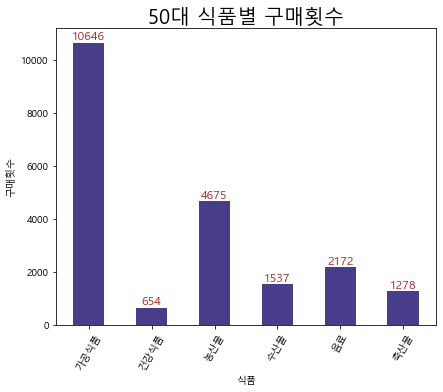

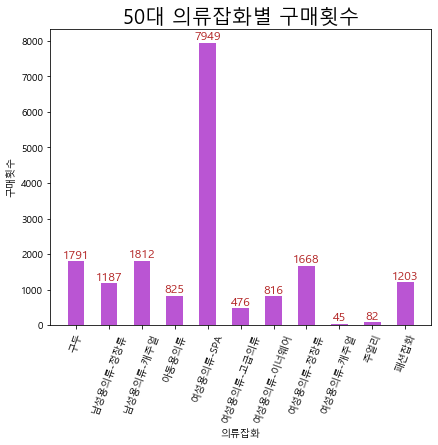

In [32]:
c_2 = df.groupby(['연령대','상품대분류명','상품중분류명'])['ID'].agg([('구매횟수','count')]).reset_index()

# 50대
c50_food = c_2.query('연령대=="50대" and 상품대분류명=="식품"')
c50_clothes = c_2.query('연령대=="50대" and 상품대분류명=="의류잡화"')

# Top1 식품
x1 = c50_food.상품중분류명
y1 = c50_food.구매횟수

plt.figure(figsize=(15,12)) 
plt.subplot(2,2,1)
plt.bar(x1,y1, color = 'darkslateblue', width = 0.5)
plt.xticks(rotation=60)
plt.xlabel("식품")
plt.ylabel("구매횟수")

plt.title("50대 식품별 구매횟수", size=20)

for i,v in enumerate(x1):
    plt.text(v, y1.iloc[i], y1.iloc[i],fontsize=12, color='firebrick',
               horizontalalignment='center', verticalalignment='bottom')

# Top2 의류잡화
x2 = c50_clothes.상품중분류명
y2 = c50_clothes.구매횟수

plt.figure(figsize=(15,12)) 
plt.subplot(2,2,2)
plt.bar(x2,y2, color = 'mediumorchid', width = 0.5)
plt.xticks(rotation=70)
plt.xlabel("의류잡화")
plt.ylabel("구매횟수")

plt.title("50대 의류잡화별 구매횟수", size=20)

for i,v in enumerate(x2):
    plt.text(v, y2.iloc[i], y2.iloc[i],fontsize=12, color='firebrick',
               horizontalalignment='center', verticalalignment='bottom')

plt.show()

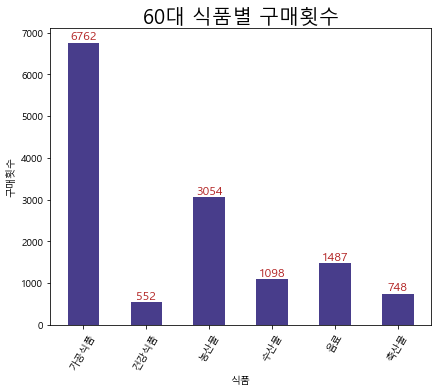

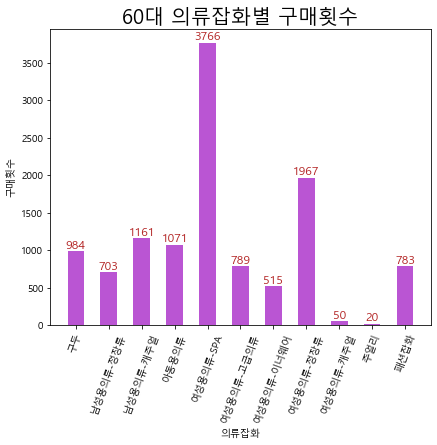

In [33]:
# 60대
c60_food = c_2.query('연령대=="60대" and 상품대분류명=="식품"')
c60_clothes = c_2.query('연령대=="60대" and 상품대분류명=="의류잡화"')

# Top1 식품
x1 = c60_food.상품중분류명
y1 = c60_food.구매횟수

plt.figure(figsize=(15,12)) 
plt.subplot(2,2,1)
plt.bar(x1,y1, color = 'darkslateblue', width = 0.5)
plt.xticks(rotation=60)
plt.xlabel("식품")
plt.ylabel("구매횟수")

plt.title("60대 식품별 구매횟수", size=20)

for i,v in enumerate(x1):
    plt.text(v, y1.iloc[i], y1.iloc[i],fontsize=12, color='firebrick',
               horizontalalignment='center', verticalalignment='bottom')

# Top2 의류잡화
x2 = c60_clothes.상품중분류명
y2 = c60_clothes.구매횟수

plt.figure(figsize=(15,12)) 
plt.subplot(2,2,2)
plt.bar(x2,y2, color = 'mediumorchid', width = 0.5)
plt.xticks(rotation=70)
plt.xlabel("의류잡화")
plt.ylabel("구매횟수")

plt.title("60대 의류잡화별 구매횟수", size=20)

for i,v in enumerate(x2):
    plt.text(v, y2.iloc[i], y2.iloc[i],fontsize=12, color='firebrick',
               horizontalalignment='center', verticalalignment='bottom')

plt.show()

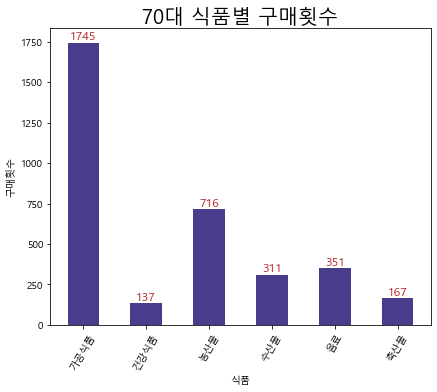

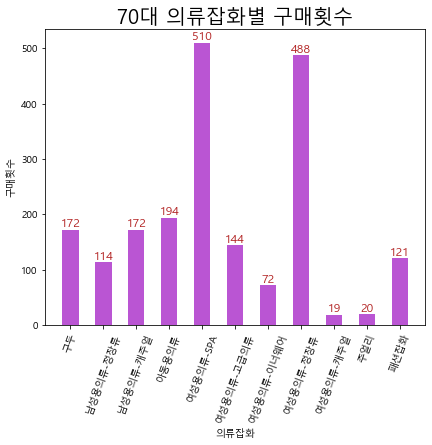

In [34]:
# 70대
c70_food = c_2.query('연령대=="70대" and 상품대분류명=="식품"')
c70_clothes = c_2.query('연령대=="70대" and 상품대분류명=="의류잡화"')

# Top1 식품
x1 = c70_food.상품중분류명
y1 = c70_food.구매횟수

plt.figure(figsize=(15,12)) 
plt.subplot(2,2,1)
plt.bar(x1,y1, color = 'darkslateblue', width = 0.5)
plt.xticks(rotation=60)
plt.xlabel("식품")
plt.ylabel("구매횟수")

plt.title("70대 식품별 구매횟수", size=20)

for i,v in enumerate(x1):
    plt.text(v, y1.iloc[i], y1.iloc[i],fontsize=12, color='firebrick',
               horizontalalignment='center', verticalalignment='bottom')

# Top2 의류잡화
x2 = c70_clothes.상품중분류명
y2 = c70_clothes.구매횟수

plt.figure(figsize=(15,12)) 
plt.subplot(2,2,2)
plt.bar(x2,y2, color = 'mediumorchid', width = 0.5)
plt.xticks(rotation=70)
plt.xlabel("의류잡화")
plt.ylabel("구매횟수")

plt.title("70대 의류잡화별 구매횟수", size=20)

for i,v in enumerate(x2):
    plt.text(v, y2.iloc[i], y2.iloc[i],fontsize=12, color='firebrick',
               horizontalalignment='center', verticalalignment='bottom')

plt.show()

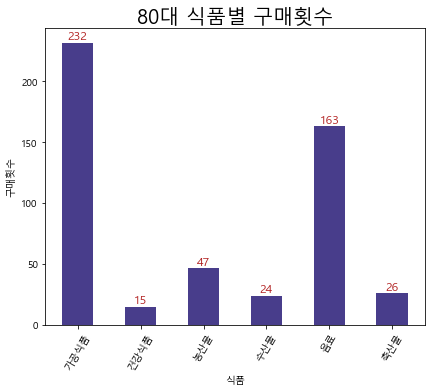

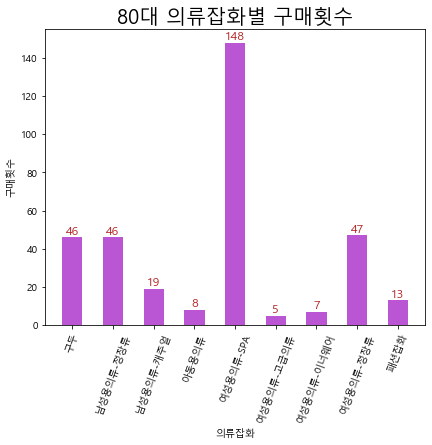

In [35]:
# 80대
c80_food = c_2.query('연령대=="80대" and 상품대분류명=="식품"')
c80_clothes = c_2.query('연령대=="80대" and 상품대분류명=="의류잡화"')

# Top1 식품
x1 = c80_food.상품중분류명
y1 = c80_food.구매횟수

plt.figure(figsize=(15,12)) 
plt.subplot(2,2,1)
plt.bar(x1,y1, color = 'darkslateblue', width = 0.5)
plt.xticks(rotation=60)
plt.xlabel("식품")
plt.ylabel("구매횟수")

plt.title("80대 식품별 구매횟수", size=20)

for i,v in enumerate(x1):
    plt.text(v, y1.iloc[i], y1.iloc[i],fontsize=12, color='firebrick',
               horizontalalignment='center', verticalalignment='bottom')

# Top2 의류잡화
x2 = c80_clothes.상품중분류명
y2 = c80_clothes.구매횟수

plt.figure(figsize=(15,12)) 
plt.subplot(2,2,2)
plt.bar(x2,y2, color = 'mediumorchid', width = 0.5)
plt.xticks(rotation=70)
plt.xlabel("의류잡화")
plt.ylabel("구매횟수")

plt.title("80대 의류잡화별 구매횟수", size=20)

for i,v in enumerate(x2):
    plt.text(v, y2.iloc[i], y2.iloc[i],fontsize=12, color='firebrick',
               horizontalalignment='center', verticalalignment='bottom')
    
plt.show()

### 50대
##### 식품 중 중분류 상품
Top1. 가공식품 (월등)
Top2. 농산물
##### 의류잡화 중 중분류 상품
Top1. 여성용의류_SPA (월등)
Top2. 남성용의류_캐주얼


### 60대
##### 식품 중 중분류 상품
Top1. 가공식품 (월등)
Top2. 농산물
##### 의류잡화 중 중분류 상품
Top1. 여성용의류_SPA (월등)
Top2. 여성용의류_정장류


### 70대
##### 식품 중 중분류 상품
Top1. 가공식품 (월등)
Top2. 농산물
##### 의류잡화 중 중분류 상품
Top1. 여성용의류_SPA
Top2. 여성용의류_정장류
(둘이 별로 차이는 안나고, 둘다 월등)


### 80대
##### 식품 중 중분류 상품
Top1. 가공식품
Top2. 음료
(둘다 월등)
##### 의류잡화 중 중분류 상품
Top1. 여성용의류_SPA (월등)
Top2. 여성용의류_정장류
Top3. 남성용의류_정장류 / 구두
(여성용의류_정장류 / 남성용의류_정장류 / 구두 -> 세개다 비슷 1개차이밖에 안남)

### 상품 대분류 & 그중 중분류에서 어떤게 소비가 많은지

In [36]:
df = pd.read_csv('df1.csv')
df1= df.drop(['거주지역','구매지역','년도','월','일','요일','구매시간'], axis=1)

df1.groupby(['상품대분류명','상품중분류명'])['ID'].agg([('구매횟수','count')])#.reset_index()

구매횟수
상품대분류명 상품중분류명              
가구     가구               734
가전제품   PC/노트북/프린터/카메라   313
       TV/AV           1153
       생활가전            3029
       주방가전            5112
...                     ...
의류잡화   여성용의류-이너웨어      1410
       여성용의류-정장류       4170
       여성용의류-캐주얼        114
       주얼리              122
       패션잡화            2120

[31 rows x 1 columns]

#### 상품대분류명 순위

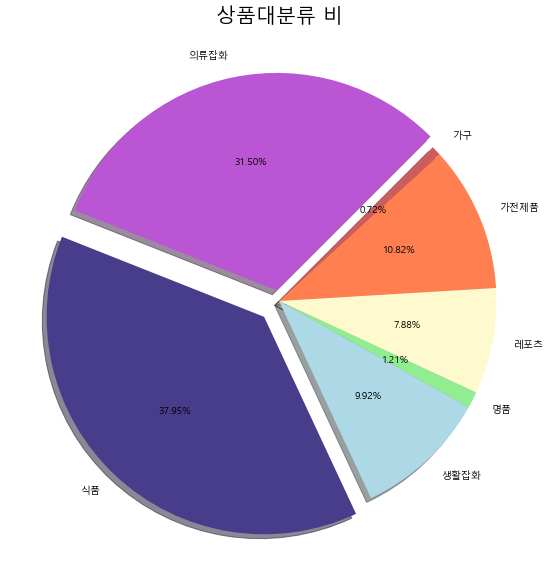

In [37]:
a = df1.groupby(['상품대분류명'])['ID'].agg([('구매횟수','count')]).reset_index()

colors = ['indianred','coral','lemonchiffon','lightgreen','lightblue','darkslateblue','mediumorchid']

# 1
plt.figure(figsize=(12,10)) 
explode1 = [0,0,0,0,0,0.1,0.05]

plt.pie(x=a.구매횟수 ,labels = a.상품대분류명, explode = explode1, 
        autopct='%.2f%%', startangle=45, counterclock = False, shadow=True, colors=colors )
plt.title('상품대분류 비', size=20)

plt.show()

식품 1위 의류잡화 2위 가전제품 3위

#### 상품중분류명 순위

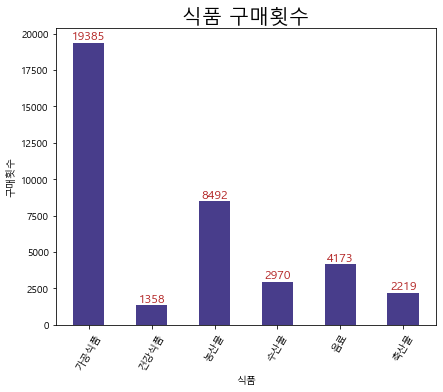

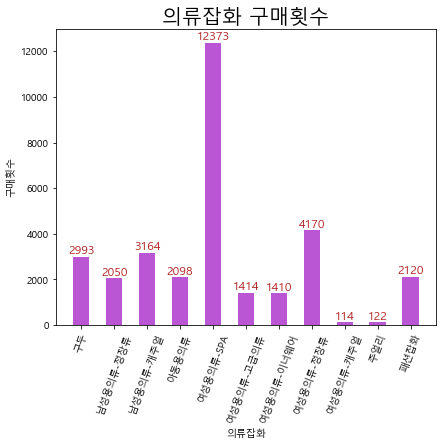

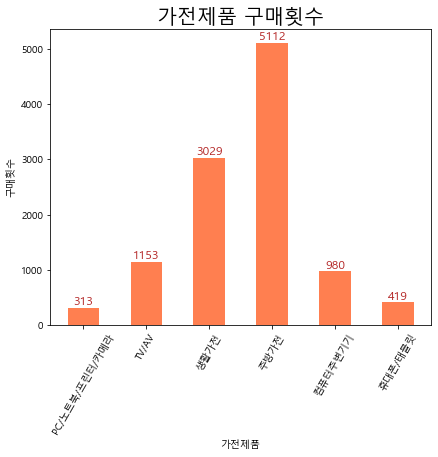

In [38]:
a1 = df1.groupby(['상품대분류명','상품중분류명'])['ID'].agg([('구매횟수','count')]).reset_index()

a_food = a1.query('상품대분류명=="식품"')
a_clothes = a1.query('상품대분류명=="의류잡화"')
a_elect = a1.query('상품대분류명=="가전제품"')


# Top1 식품
x1 = a_food.상품중분류명
y1 = a_food.구매횟수

plt.figure(figsize=(15,12)) 
plt.subplot(2,2,1)
plt.bar(x1,y1, color = 'darkslateblue', width = 0.5)
plt.xticks(rotation=60)
plt.xlabel("식품")
plt.ylabel("구매횟수")

plt.title("식품 구매횟수", size=20)

for i,v in enumerate(x1):
    plt.text(v, y1.iloc[i], y1.iloc[i],fontsize=12, color='firebrick',
               horizontalalignment='center', verticalalignment='bottom')

# Top2 의류잡화
x2 = a_clothes.상품중분류명
y2 = a_clothes.구매횟수

plt.figure(figsize=(15,12)) 
plt.subplot(2,2,2)
plt.bar(x2,y2, color = 'mediumorchid', width = 0.5)
plt.xticks(rotation=70)
plt.xlabel("의류잡화")
plt.ylabel("구매횟수")

plt.title("의류잡화 구매횟수", size=20)

for i,v in enumerate(x2):
    plt.text(v, y2.iloc[i], y2.iloc[i],fontsize=12, color='firebrick',
               horizontalalignment='center', verticalalignment='bottom')
    
# Top3 가전제품
x3 = a_elect.상품중분류명
y3 = a_elect.구매횟수

plt.figure(figsize=(15,12)) 
plt.subplot(2,2,3)
plt.bar(x3,y3, color = 'coral', width = 0.5)
plt.xticks(rotation=60)
plt.xlabel("가전제품")
plt.ylabel("구매횟수")

plt.title("가전제품 구매횟수", size=20)

for i,v in enumerate(x3):
    plt.text(v, y3.iloc[i], y3.iloc[i],fontsize=12, color='firebrick',
               horizontalalignment='center', verticalalignment='bottom')

식품 중 가공식품이 1위
의류잡화 중 여성용의류_SPA 1위
가전제품 중 주방가전 1위

### 구매금액 분위수 제품 상세

In [39]:
df = pd.read_csv('df1.csv')
df1 = df.drop(['구매시간','년도','월','일','요일','거주지역','구매지역','구매일자'],axis=1)
del(df)
df2 = df1[df1.구매금액 > 0 ]
df2.describe().astype(int)

df2['금액분위수'] = df2.구매금액.apply(quan)

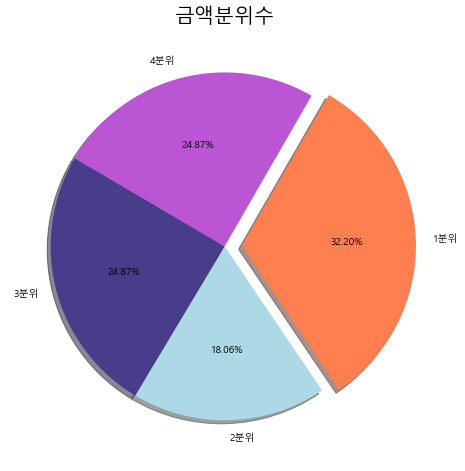

In [40]:
a=df2.groupby(['금액분위수'])['ID'].agg([('구매횟수','count')]).reset_index()

colors = ['coral','lightblue','darkslateblue','mediumorchid']

plt.figure(figsize=(10,8)) 
explode1 = [0.1,0,0,0]

plt.pie(x=a.구매횟수 ,labels = a.금액분위수, explode = explode1, 
        autopct='%.2f%%', startangle=60, counterclock = False, shadow=True, colors=colors )
plt.title('금액분위수', size=20)

plt.show()

#### 각 구매금액 분위수 중 어떤 제품이 많은가

In [41]:
df2.groupby(['금액분위수','상품대분류명','상품중분류명'])['ID'].agg([('구매횟수','count')])#.reset_index()

구매횟수
금액분위수 상품대분류명 상품중분류명              
1분위   가구     가구                98
      가전제품   PC/노트북/프린터/카메라     2
             TV/AV              2
             생활가전             145
             주방가전             449
...                           ...
4분위   의류잡화   여성용의류-이너웨어       246
             여성용의류-정장류       1923
             여성용의류-캐주얼         25
             주얼리               86
             패션잡화             502

[124 rows x 1 columns]

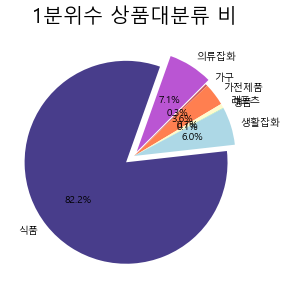

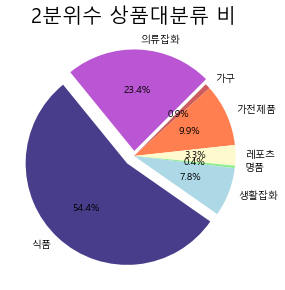

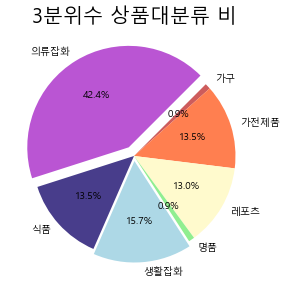

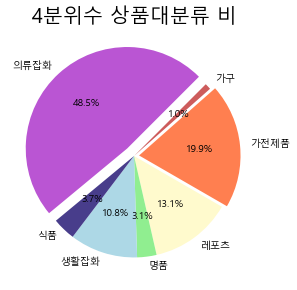

In [42]:
q1=df2.query('금액분위수=="1분위"').groupby(['상품대분류명'])['ID'].agg([('1분위구매횟수','count')]).reset_index()
q2=df2.query('금액분위수=="2분위"').groupby(['상품대분류명'])['ID'].agg([('2분위구매횟수','count')]).reset_index()
q3=df2.query('금액분위수=="3분위"').groupby(['상품대분류명'])['ID'].agg([('3분위구매횟수','count')]).reset_index()
q4=df2.query('금액분위수=="4분위"').groupby(['상품대분류명'])['ID'].agg([('4분위구매횟수','count')]).reset_index()


colors = ['indianred','coral','lemonchiffon','lightgreen','lightblue','darkslateblue','mediumorchid']

# 1
plt.figure(figsize=(10,20))
plt.subplot(2,2,1)
explode1 = [0,0,0,0,0,0.1,0.05]
plt.pie(x=q1['1분위구매횟수'] ,labels = q1.상품대분류명, explode = explode1, 
        autopct='%.1f%%', startangle=45, counterclock = False, shadow=False, colors=colors )
plt.title('1분위수 상품대분류 비', size=20)

# 2
plt.figure(figsize=(10,20))
plt.subplot(2,2,2)
explode1 = [0,0,0,0,0,0.1,0.05]
plt.pie(x=q2['2분위구매횟수'] ,labels = q2.상품대분류명, explode = explode1, 
        autopct='%.1f%%', startangle=45, counterclock = False, shadow=False, colors=colors )
plt.title('2분위수 상품대분류 비', size=20)

# 3
plt.figure(figsize=(10,20))
plt.subplot(2,2,3)
explode1 = [0,0,0,0,0.05,0,0.1]
plt.pie(x=q3['3분위구매횟수'] ,labels = q3.상품대분류명, explode = explode1, 
        autopct='%.1f%%', startangle=45, counterclock = False, shadow=False, colors=colors )
plt.title('3분위수 상품대분류 비', size=20)

# 4
plt.figure(figsize=(10,20))
plt.subplot(2,2,4)
explode1 = [0,0.05,0,0,0,0,0.1]
plt.pie(x=q4['4분위구매횟수'] ,labels = q4.상품대분류명, explode = explode1, 
        autopct='%.1f%%', startangle=45, counterclock = False, shadow=False, colors=colors )
plt.title('4분위수 상품대분류 비', size=20)


plt.show()

1,2분위의 절반 이상은 식품이 차지
3,4분위 약 절반은 의류잡화가 차지

#### 각분위수의 상품대분류 1등 중 상품중분류비

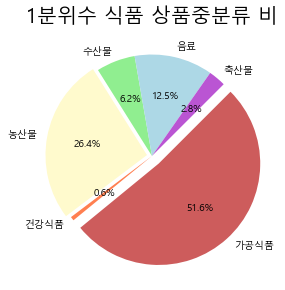

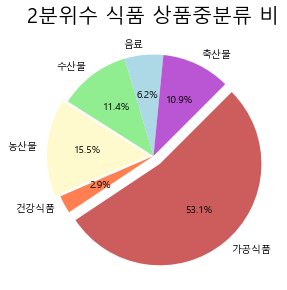

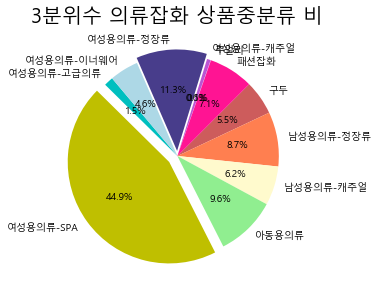

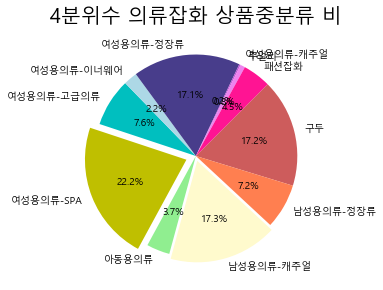

In [43]:
q11=df2.query('금액분위수=="1분위" and 상품대분류명=="식품"').groupby(['상품중분류명'])['ID'].agg([('1분위구매횟수','count')]).reset_index()
q22=df2.query('금액분위수=="2분위" and 상품대분류명=="식품"').groupby(['상품중분류명'])['ID'].agg([('2분위구매횟수','count')]).reset_index()
q33=df2.query('금액분위수=="3분위" and 상품대분류명=="의류잡화"').groupby(['상품중분류명'])['ID'].agg([('3분위구매횟수','count')]).reset_index()
q44=df2.query('금액분위수=="4분위" and 상품대분류명=="의류잡화"').groupby(['상품중분류명'])['ID'].agg([('4분위구매횟수','count')]).reset_index()


colors1 = ['indianred','coral','lemonchiffon','lightgreen','lightblue','mediumorchid']
colors2 = ['indianred','coral','lemonchiffon','lightgreen','y','c','lightblue','darkslateblue','mediumorchid','violet','deeppink']


# 1
plt.figure(figsize=(10,20))
plt.subplot(2,2,1)
explode1 = [0.1,0,0.05,0,0,0]
plt.pie(x=q11['1분위구매횟수'] ,labels = q11.상품중분류명, explode = explode1, 
        autopct='%.1f%%', startangle=45, counterclock = False, shadow=False, colors=colors1 )
plt.title('1분위수 식품 상품중분류 비', size=20)

# 2
plt.figure(figsize=(10,20))
plt.subplot(2,2,2)
explode1 = [0.1,0,0.05,0,0,0]
plt.pie(x=q22['2분위구매횟수'] ,labels = q22.상품중분류명, explode = explode1, 
        autopct='%.1f%%', startangle=45, counterclock = False, shadow=False, colors=colors1 )
plt.title('2분위수 식품 상품중분류 비', size=20)

# 3
plt.figure(figsize=(10,20))
plt.subplot(2,2,3)
explode1 = [0,0,0,0,0.1,0,0,0.05,0,0,0]
plt.pie(x=q33['3분위구매횟수'] ,labels = q33.상품중분류명, explode = explode1, 
        autopct='%.1f%%', startangle=45, counterclock = False, shadow=False, colors=colors2 )
plt.title('3분위수 의류잡화 상품중분류 비', size=20)

# 4
plt.figure(figsize=(10,20))
plt.subplot(2,2,4)
explode1 = [0,0,0.05,0,0.1,0,0,0,0,0,0]
plt.pie(x=q44['4분위구매횟수'] ,labels = q44.상품중분류명, explode = explode1, 
        autopct='%.1f%%', startangle=45, counterclock = False, shadow=False, colors=colors2 )
plt.title('4분위수 의류잡화 상품중분류 비', size=20)


plt.show()

1,2분위의 식품 중 가공식품이 절반이상 차지
3,4분위 의류잡화 중 여성용의류_SPA가 1위

## 구매지역 별 소비가 많은 제품
### +거주지역과 구매지역의 일치성
### +구매지역/거주지역 별 소비 총 금액 순위

#### 비슷한지역에서 사는지 멀리가서 사는지
##### 멀리서 살때 고가제품위주? 저가제품위주?
##### 가까이서 살때 고가제품위주? 저가제품위주?

#### +거주지역과 구매지역의 일치성

In [44]:
# 거주,구매지역 숫자로 바꿔서 비교 쉽게

df = pd.read_csv('df1.csv')
df.head()

df1 = df.drop(['ID','년도','월','일','요일','구매시간','성별','구매일자','구매수량','취소여부'], axis=1)
df1.head()

df1['거주지역_시'] = df1.거주지역.apply(lambda x: x.split(' ')[0])
df1['거주지역_구'] = df1.거주지역.apply(lambda x: x.split(' ')[1])

df1['구매지역_시'] = df1.구매지역.apply(lambda x: x.split(' ')[0])
df1['구매지역_구'] = df1.구매지역.apply(lambda x: x.split(' ')[1])

df2 = df1.drop(['거주지역','구매지역'], axis=1)

def city(x):
    if x == '서울':
        return 1
    elif x == '경기':
        return 2
    else:
        return 3

df2['거주지역_시']=df2['거주지역_시'].apply(city).astype(str)
df2['구매지역_시']=df2['구매지역_시'].apply(city).astype(str)

df3 = df2.drop(['연령','구매금액'], axis=1)

g1 = df3.query('거주지역_시 == "1"')['거주지역_구'].values.tolist()
n_g1 = list(sorted(set(g1)))

g2 = df3.query('거주지역_시 == "2"')['거주지역_구'].values.tolist()
n_g2 = list(sorted(set(g2)))

g3 = df3.query('거주지역_시 == "3"')['거주지역_구'].values.tolist()
n_g3 = list(sorted(set(g3)))

def gu(x):
    if x in n_g1:
        return n_g1.index(x)
    elif x in n_g2:
        return n_g2.index(x)
    elif x in n_g3:
        return n_g3.index(x)


b1 = df3.query('구매지역_시 == "1"')['구매지역_구'].values.tolist()
n_b1 = list(sorted(set(b1)))

b2 = df3.query('구매지역_시 == "2"')['구매지역_구'].values.tolist()
n_b2 = list(sorted(set(b2)))

b3 = df3.query('구매지역_시 == "3"')['구매지역_구'].values.tolist()
n_b3 = list(sorted(set(b3)))

def b_gu(x):
    if x in n_b1:
        return n_b1.index(x)
    elif x in n_b2:
        return n_b2.index(x)
    elif x in n_b3:
        return n_b3.index(x)


def two(x):
    if len(x) ==1:
        return '0'+x
    elif len(x)==2:
        return x
    
df3['거주지역_구'] = df3['거주지역_구'].apply(gu).astype(str).apply(two)
df3['구매지역_구'] = df3['구매지역_구'].apply(b_gu).astype(str).apply(two)

a1= [i for i in df3['거주지역_시']]
a2= [j for j in df3['거주지역_구']]

b1= [k for k in df3['구매지역_시']]
b2= [l for l in df3['구매지역_구']]

c = list(zip(a1,a2))
d = list(zip(b1,b2))
df3['거주지역'] = c
df3['구매지역'] = d

df3['거주지역'] = [i+j for i,j in df3['거주지역']]
df3['구매지역'] = [i+j for i,j in df3['구매지역']]


df3['거주지역_시']=df3['거주지역_시'].astype(int)
df3['구매지역_시']=df3['구매지역_시'].astype(int)
df3['거주지역_구'] = df3['거주지역_구'].astype(int)
df3['구매지역_구'] = df3['구매지역_구'].astype(int)
df3['거주지역'] = df3['거주지역'].astype(int)
df3['구매지역'] = df3['구매지역'].astype(int)

df3


,상품대분류명,상품중분류명,거주지역_시,거주지역_구,구매지역_시,구매지역_구,거주지역,구매지역
0,가전제품,컴퓨터주변기기,1,15,1,10,115,110
1,가전제품,TV/AV,1,15,1,10,115,110
2,가전제품,주방가전,1,15,1,22,115,122
3,의류잡화,여성용의류-이너웨어,1,15,1,10,115,110
4,생활잡화,화장품,1,14,1,22,114,122
...,...,...,...,...,...,...,...,...
101687,의류잡화,남성용의류-정장류,2,23,2,14,223,214
101688,의류잡화,패션잡화,2,23,2,14,223,214
101689,가전제품,생활가전,2,23,2,14,223,214
101690,식품,가공식품,2,16,2,1,216,201


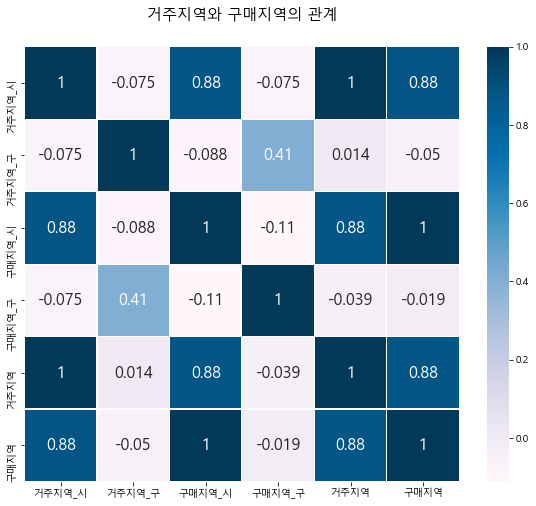

In [45]:
colormap = plt.cm.PuBu
plt.figure(figsize=(10, 8))
plt.title("거주지역와 구매지역의 관계", y = 1.05, size = 15)
sns.heatmap(df3.corr(), linewidths = 0.1, vmax = 1.0,
            square = True, cmap = colormap, linecolor = "white", annot = True, annot_kws = {"size" : 16})
plt.show()

1. 거주지역 구매지역 일치하는지 비교
2. 거주지역(시)랑 구매지역(시) 일치하는지 비교
3. (시)일치 수 - 전체일치 수 = 시는 같은데 구는 다른곳

### 구매지역 별 소비가 많은 제품

In [46]:
df = pd.read_csv('df1.csv')
df.head()

df = df.drop(['년도','월','일','요일','구매시간','구매일자'], axis=1)
df['거주지역_시'] = df.거주지역.apply(lambda x: x.split(' ')[0])
df['구매지역_시'] = df.구매지역.apply(lambda x: x.split(' ')[0])
df.head()

,ID,성별,연령,거주지역,상품대분류명,상품중분류명,구매지역,구매수량,구매금액,취소여부,거주지역_시,구매지역_시
0,478207946,1,84,서울 성동구,가전제품,컴퓨터주변기기,서울 동대문구,1,59000,0,서울,서울
1,478207946,1,84,서울 성동구,가전제품,TV/AV,서울 동대문구,1,106000,0,서울,서울
2,478207946,1,84,서울 성동구,가전제품,주방가전,서울 중구,1,37000,0,서울,서울
3,478207946,1,84,서울 성동구,의류잡화,여성용의류-이너웨어,서울 동대문구,1,118000,0,서울,서울
4,479806984,1,84,서울 서초구,생활잡화,화장품,서울 중구,1,22000,0,서울,서울


In [ ]:
b = df.groupby('구매지역_시')['ID'].agg([('구매횟수','count')]).reset_index()

colors = ['lemonchiffon','lightblue','mediumorchid']

plt.figure(figsize=(12,10)) 
plt.subplot(2,2,1)
explode1 = [0,0,0.1]

plt.pie(x=b.구매횟수 ,labels = b.구매지역_시, explode = explode1, 
        autopct='%.2f%%', startangle=45, counterclock = False, shadow=True, colors=colors )
plt.title('구매지역', size=20)
plt.show()

In [ ]:
a=df.groupby(['구매지역_시','상품대분류명'])['ID'].agg([('구매횟수','count')]).reset_index()
a_s= a.query('구매지역_시=="서울"')
a_g= a.query('구매지역_시=="경기"')
a_b= a.query('구매지역_시=="부산"')


colors = ['indianred','coral','lemonchiffon','lightgreen','lightblue','darkslateblue','mediumorchid']

# 서울
plt.figure(figsize=(12,10)) 
plt.subplot(2,2,1)
explode1 = [0,0,0,0,0,0.1,0.05]

plt.pie(x=a_s.구매횟수 ,labels = a_s.상품대분류명, explode = explode1, 
        autopct='%.2f%%', startangle=45, counterclock = False, shadow=True, colors=colors )
plt.title('서울구매 상품대분류 비', size=20)


# 경기
plt.figure(figsize=(12,10)) 
plt.subplot(2,2,2)
explode1 = [0,0,0,0,0,0.1,0.05]

plt.pie(x=a_g.구매횟수 ,labels = a_g.상품대분류명, explode = explode1, 
        autopct='%.2f%%', startangle=45, counterclock = False, shadow=True, colors=colors )
plt.title('경기구매 상품대분류 비', size=20)


# 부산
plt.figure(figsize=(12,10)) 
plt.subplot(2,2,3)
explode1 = [0,0,0,0,0,0.1,0.05]

plt.pie(x=a_b.구매횟수 ,labels = a_b.상품대분류명, explode = explode1, 
        autopct='%.2f%%', startangle=45, counterclock = False, shadow=True, colors=colors )
plt.title('부산구매 상품대분류 비', size=20)


plt.show()